# Damped-Local-Trend(DLT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.dlt import DLT
from orbit.utils.utils import plot_predicted_data

## Data

In [2]:
DATA_FILE = "./data/iclaims.example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

### Data Transformation

In [5]:
df=raw_df.copy()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df=df[-test_size:]

## MAP Fit and Predict

In [7]:
dlt_map=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [8]:
dlt_map.fit(df=train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18ed11b37ce6dc899a2c9c583d39bff7 NOW.


In [9]:
dlt_map.aggregated_posteriors

{'mean': None,
 'median': None,
 'map': {'l': array([[13.91715185, 13.91703346, 13.91877554, 13.91749257, 13.92044065,
          13.9228362 , 13.92464022, 13.92794759, 13.93184438, 13.93158233,
          13.93271291, 13.933039  , 13.93269347, 13.93368008, 13.93349919,
          13.93118657, 13.9287195 , 13.92749561, 13.92538679, 13.92596178,
          13.9246931 , 13.9235334 , 13.92255289, 13.92254255, 13.92121755,
          13.92116166, 13.92245071, 13.92231341, 13.92147944, 13.92343905,
          13.92746135, 13.93133092, 13.9327787 , 13.93166334, 13.93089886,
          13.92889962, 13.92465579, 13.9225907 , 13.92274609, 13.92236861,
          13.92230733, 13.91886715, 13.91607246, 13.91560316, 13.91492609,
          13.91331171, 13.91011934, 13.90809688, 13.90750236, 13.90635406,
          13.90700411, 13.90348797, 13.90479269, 13.91287392, 13.90502928,
          13.91575868, 13.91266184, 13.90969671, 13.91035436, 13.90412048,
          13.88472252, 13.88909626, 13.8881765 , 13.8890

In [13]:
predicted_df = dlt_map.predict(df=test_df)

In [14]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,12.425102
1,2017-07-09,12.545344
2,2017-07-16,12.382644
3,2017-07-23,12.236148
4,2017-07-30,12.189422


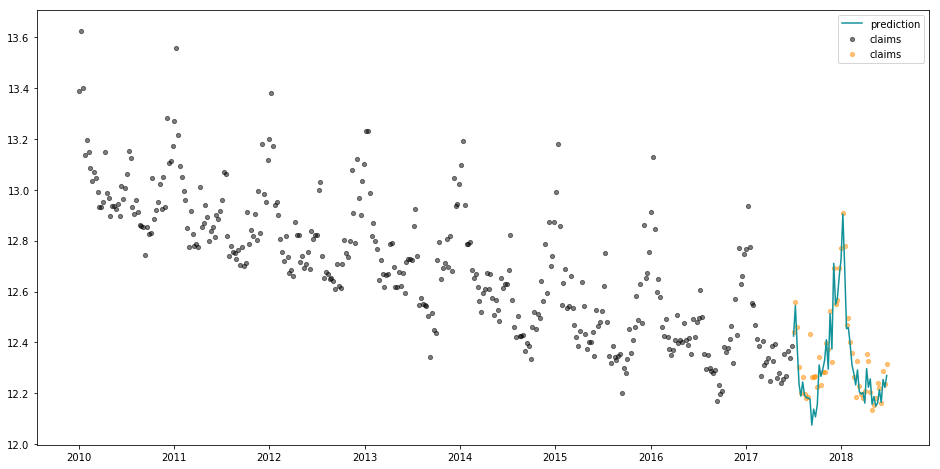

In [15]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_map.date_col, actual_col=dlt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [16]:
dlt_mcmc = DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [17]:
dlt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [18]:
predicted_df = dlt_mcmc.predict(df=test_df)

In [19]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,12.113447,12.235838,12.353749
48,2018-06-03,12.055194,12.176508,12.292269
49,2018-06-10,12.144826,12.270732,12.384796
50,2018-06-17,12.119082,12.239316,12.363908
51,2018-06-24,12.161672,12.284007,12.406118


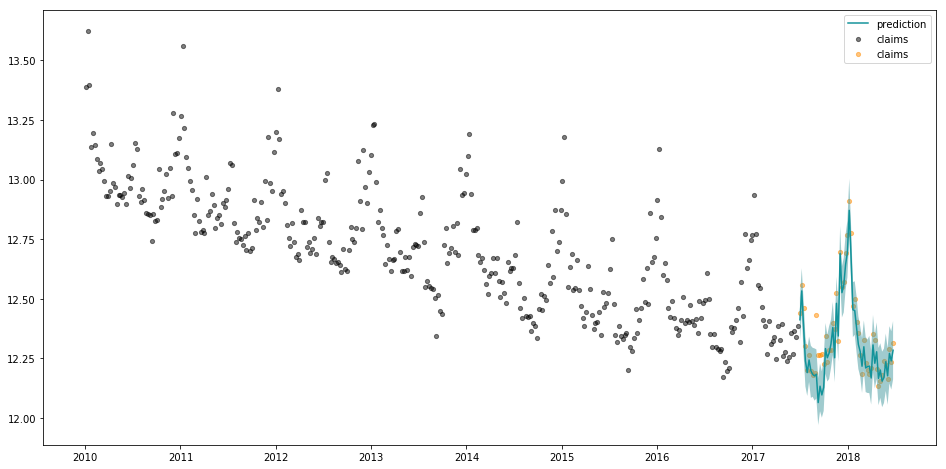

In [20]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mcmc.date_col, actual_col=dlt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit and Predict Decomp

In [21]:
dlt_mean=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [22]:
dlt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [23]:
predicted_df = dlt_mean.predict(df=test_df, decompose=True)

In [24]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.412107,12.356003,0.056103,0.0
1,2017-07-09,12.529764,12.354077,0.175687,0.0
2,2017-07-16,12.379536,12.352145,0.027391,0.0
3,2017-07-23,12.233662,12.350209,-0.116547,0.0
4,2017-07-30,12.183859,12.348269,-0.164410,0.0


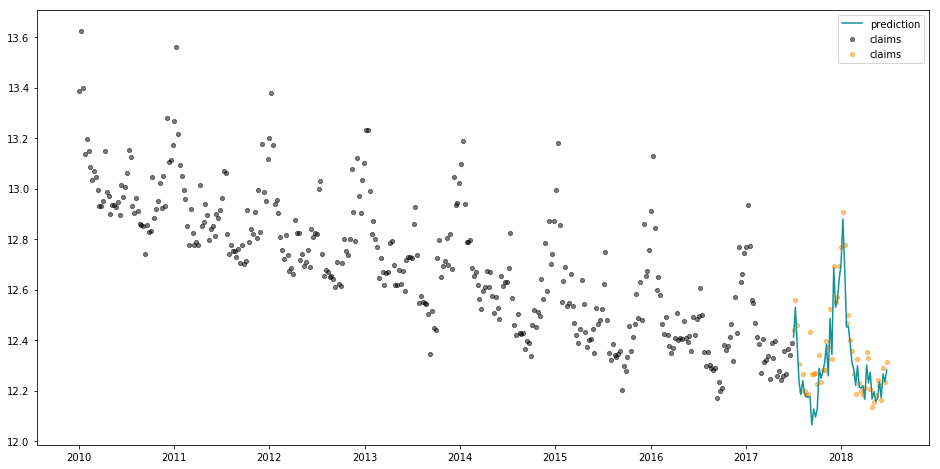

In [25]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mean.date_col, actual_col=dlt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MAP Fit and Decomp with Regression

In [26]:
dlt_reg=DLT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [27]:
dlt_reg.fit(df=train_df)

In [28]:
predicted_df = dlt_reg.predict(df=test_df, decompose=True)

In [29]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.505499,12.345295,0.145144,0.015061
1,2017-07-09,12.551526,12.347341,0.207846,-0.003660
2,2017-07-16,12.331293,12.349387,-0.026219,0.008124
3,2017-07-23,12.217347,12.351434,-0.134221,0.000135
4,2017-07-30,12.230298,12.353481,-0.126960,0.003777
